1. Initialize road capacity matrix, with the number 0 to represent residential areas and
   the number 2-5 to represent roads with different widths. Also initialize
   traffic volume distribution matrix with the same dimension, initialized to
   all 0, regarded as no traffic volume.
2. Partial cells are selected randomly according to density and generation rules
   to randomly generate trafffic flows.
3. Determine the destination for each unit of traffic flow.
4. According to parallel and nearest rule (distance) and conflict avoidance, the
   traffic flows are updated. When an iteration is complete, generate a new
   traffic flow and add it to the matrix.
5. Repeat steps 3-4 until the traffic flow matrix the maximum number of
   iterations have transpired.
6. The traffic distribution in the ciry at each timestep and the traffic
   trajectory generated at different time steps are output.

In [52]:
from dataclasses import dataclass

import numpy as np
from numpy.random import default_rng
import seaborn as sns

from traffic_sim.core import example


In [53]:
@dataclass
class TrafficFlow():
    location:tuple
    dest:tuple
    capacity:int
    possible_moves:dict = None

    def get_move_params(self):
        i, j = self.location
        x, y = self.dest
        return i, j, x, y

    def get_possible_moves(self):
        return list(self.possible_moves.keys())

    def reset_possible_moves(self):
        i, j, x, y = self.get_move_params()
        self.possible_moves = {
            (i, j):(i-x)^2 + (j-y)^2,      # L(i,j)
            (i+1, j):(i+1-x)^2 + (j-y)^2,    # L(i+1,j)
            (i-1, j):(i-1-x)^2 + (j-y)^2,    # L(i-1,j)
            (i, j+1):(i-x)^2 + (j+1-y)^2,    # L(i,j+1)
            (i+1, j+1):(i+1-x)^2 + (j+1-y)^2,  # L(i+1,j+1)
        }

    def unset_possible_move(self, move:tuple):
        """
        Given a move, remove it as a possible move (due to full capacity).
        """
        del self.possible_moves[move]

    def step(self):
        """
        Calculate the next step to move from the current location to the
        destination and update the current location.
        """
        self.location = min(self.get_possible_moves())


class TrafficMatrix():
    def __init__(
            self,
            rows:int,
            cols:int,
            density:float = 0.05,
            random_seed:bool = None):
        """
        Initialize a traffic capacity matrix and traffic volume matrix with the
        given size (rows, cols).
        """
        self.rng = default_rng(seed=random_seed)
        self.rows = rows
        self.cols = cols
        self.density = density
        self.flows = []

        # capacity matrix
        self.cmatrix = np.zeros((rows, cols), dtype=int)

        # volume matrix
        self.vmatrix = np.zeros((rows, cols), dtype=int)
        self.init()
    
    def init(self):
        """
        Hard-coded roads for the traffic matrix for developing the original
        algorithm.
        """
        # set traffic capacities
        self.cmatrix[:,2] = 2
        self.cmatrix[:,8] = 2
        self.cmatrix[3,:] = 3
        self.cmatrix[:,5] = 4

    def run(self, iterations:int):
        for _ in range(iterations):
            self.generate_flows()
            self.update_flows()
            self.update_matrix()


    def select_cells(self, num_cells:int):
        """
        Select cells in which to generate traffic flows based on density.
        """
        # select cells with traffic capacity
        idxs = np.where(self.cmatrix > 0)

        # select num_cells cells randomly
        res = self.rng.choice(range(len((idxs[0]))), num_cells, replace=False)

        return (np.array(idxs[0])[res], np.array(idxs[1])[res])

    def generate_flows(self):
        """
        Generate initial traffic flows.
        """
        num_cells = round(self.rows * self.cols * self.density) - len(self.flows)

        # create flow origins
        origins = self.select_cells(num_cells)

        origins_list = [(origins[0][i],origins[1][i]) for i in range(len(origins[0]))]

        # create flow destinations
        dests = self.select_cells(num_cells)

        dests_list = [(dests[0][i],dests[1][i]) for i in range(len(dests[0]))]

        for i in range(num_cells):
            # capacity of the flow is a random number between 1 and the capacity-1
            capacity = self.rng.choice(range(1, self.get_capacity(origins_list[i])))
            flow = TrafficFlow(origins_list[i], dests_list[i], capacity)
            flow.reset_possible_moves()
            self.flows.append(flow)

    def get_capacity(self, pos:tuple):
        """
        Return traffic cell capacity given a position.
        """
        return self.cmatrix[pos]

    def get_volume(self, pos:tuple):
        """
        Return volume
        """
        return self.vmatrix[pos]
    
    def is_full(self, pos:tuple):
        """
        Check if full
        """
        return self.get_capacity(pos) - self.get_volume(pos) > 0
    
    def in_bounds(self, pos:tuple):
        """
        Check if within bounds
        """
        return 0 <= pos[0] < self.rows and 0 <= pos[1] < self.cols

    def update_flows(self):
        """
        Get the next move for every flow, then execute each of them in 
        parallel.
        """
        for flow in self.flows:
            moves = flow.get_possible_moves()
            for move in moves:
                if not self.in_bounds(move) or self.is_full(move):
                    flow.unset_possible_move(move)
        
            flow.step()

    def update_matrix(self):
        """
        Update traffic volume matrix based on current flows.
        """
        self.vmatrix = np.zeros(self.vmatrix.shape, dtype=int)

        for flow in self.flows:
            location = flow.location
            capacity = flow.capacity
            self.vmatrix[location] += capacity


<AxesSubplot:>

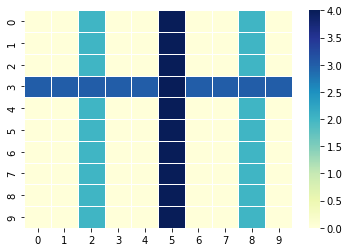

In [54]:
tm = TrafficMatrix(10, 10)
sns.heatmap(tm.cmatrix, cmap="YlGnBu", linewidth=0.5)

<AxesSubplot:>

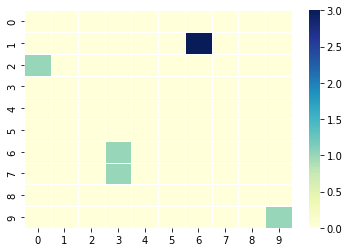

In [55]:
tm.run(5)
sns.heatmap(tm.vmatrix, cmap="YlGnBu", linewidth=0.5)